In [1]:
from counter import counter
cc = counter('count-cooc')

Loading count-cooc from disk...


In [4]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt

In [3]:
len(cc.items('t'))

932

# the math

$$ \frac{ \text{count-t}(a) }{ \sum \text{count-t}(a) } = 1 $$
$$ \sum_b{ \text{count-t.t}(a,b) } = 5 \sum \text{count-t}(a) $$

$$ P( \text{b shows up after a} ) = 1 - \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] } $$

$$ P( w_{j+N} = b | w_j = a ) = ?? $$

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) \in [0, 5] $$

Now I want to measure how surprising a given connection is compared to the individual propensities.
Something similar to // independence indicates that

$$P(A \& B) = P(A) * P(B|A) = P(A) * P(B)$$

Where the last equality expresses the independence assumption. The extent to which the leftmost and rightmost quantities differ is a good measure for the relevance of a single tie between events.
So, assume $a$ and $b$ are independent events. From above we know that

$$P(a \to b) = \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] }$$

And by independence this is just

$$ \prod_N{ \left[ 1 - P( w_{j+N} = b ) \right] } $$

$$ P( w_{j+N} = b ) = \text{count-t}(b) * 5 $$

So we almost get what we want... Let's try another combo of formulas...

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) $$
$$ = \sum_{N=1}^5 P( w_{j+N} = b ) = \sum_{N=1}^5 \frac{ \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} } = \frac{ 5 * \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} }  $$

By this math the relevant ratio is

$$ \frac{ \text{count-t.t}(a,b) * \sum_b{\text{count-t}(b)} }{ \text{count-t}(a) * \text{count-t}(b) } = 5 $$

# generate the network

In [5]:
cc.counts.keys()

dict_keys([('fy',), ('t',), ('t1', 't2'), ('t1', 't2', 'fy')])

In [45]:
tot = cc.counts[('t',)].sum()
terms = cc.items('t')

In [66]:
rats = []
pairs = []

for t1 in terms:
    for t2 in terms:
        if t1 == t2:
            continue
        
        ca = cc(t=t1)
        cb = cc(t=t2)
        cab = cc(t1=t1, t2=t2)
        
        if cab < 10 or ca < 10 or cb < 10:
            continue

        rat = tot * cab / (ca * cb)
        pairs.append( (cc.ids['t'][t1], cc.ids['t'][t2]) )
        rats.append( rat )

In [59]:
rats = np.array(rats)

In [60]:
np.argwhere( rats > 250 ).shape

(93298, 1)

In [61]:
np.argwhere( rats < 250 ).shape

(97431, 1)

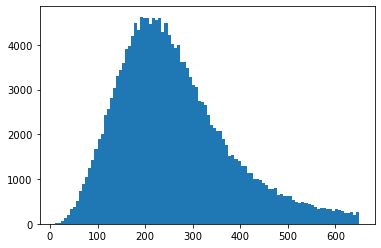

In [62]:
plt.hist( rats[(rats<250+400)&(rats>0)], bins=100 );

In [141]:
np.mean(rats)

287.8448392690185

In [63]:
np.quantile(rats, 0.9)

472.5454425269636

In [64]:
from random import sample

In [75]:
tops = np.argwhere( rats > np.quantile(rats, 0.999) ).flatten()
tops = list(tops)

for i in sample( tops, 100 ):
    ai, bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    ac = cc.counts[('t',)][ai]
    bc = cc.counts[('t',)][bi]
    abc = cc.counts[('t1','t2')][(ai,bi)]
    bac = cc.counts[('t1','t2')][(bi,ai)]
    print( (at, bt, rats[i], ac, bc, abc, bac) )

('mental-health', 'health', 2376.189283449588, 38, 166, 357, 229)
('high-school', 'family-income', 2480.990909090909, 11, 20, 13, 2)
('middle-class', 'social-class', 5152.827272727272, 22, 40, 108, 112)
('years', 'life', 2588.392067862192, 151, 178, 1657, 1678)
('social-class', 'lower', 3259.4394736842105, 40, 76, 236, 157)
('results-table', 'dependent-variables', 2999.0, 10, 14, 0, 6)
('significant-differences', 'dependent-variables', 3498.8333333333335, 12, 14, 14, 9)
('less-likely', 'two-types', 3088.6252873563217, 29, 15, 32, 13)
('independent-variables', 'three-times', 2332.5555555555557, 21, 12, 14, 0)
('john', 'cambridge-cambridge', 5351.156862745098, 34, 12, 52, 36)
('per-capita', 'models', 5825.994449583719, 23, 94, 300, 254)
('regression-analysis', 'two-sets', 2999.0, 14, 10, 10, 17)
('per-cent', 'men', 2559.161665416354, 62, 86, 325, 289)
('yale-university', 'oxford-university', 4771.136363636364, 11, 12, 15, 2)
('survey', 'life', 2629.8863489603514, 87, 178, 970, 1013)
('mo

# dump network

In [108]:
import networkx as nx

In [150]:
rats = np.array(rats)
cutoff = np.quantile(rats[rats>0], 0.995)
cutoff

1299.5666666666666

In [165]:
G = nx.DiGraph()

edges = []

for i, r in enumerate(rats):
    if r < cutoff:
        continue
    
    ai,bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    edges.append( [at,bt,r] )

G.add_weighted_edges_from(edges)

In [166]:
edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items()])

In [167]:
deg = np.array(list(x[1] for x in G.degree()))

In [168]:
np.where( deg < 3 )[0].shape

(148,)

In [169]:
G.remove_nodes_from( list(np.where( deg < 3 )[0]) )

In [171]:
Gcomp_nodes = list( nx.connected_components(G.to_undirected()) )[0]
Gcomp = nx.subgraph(G, Gcomp_nodes)

pos = nx.kamada_kawai_layout(Gcomp)

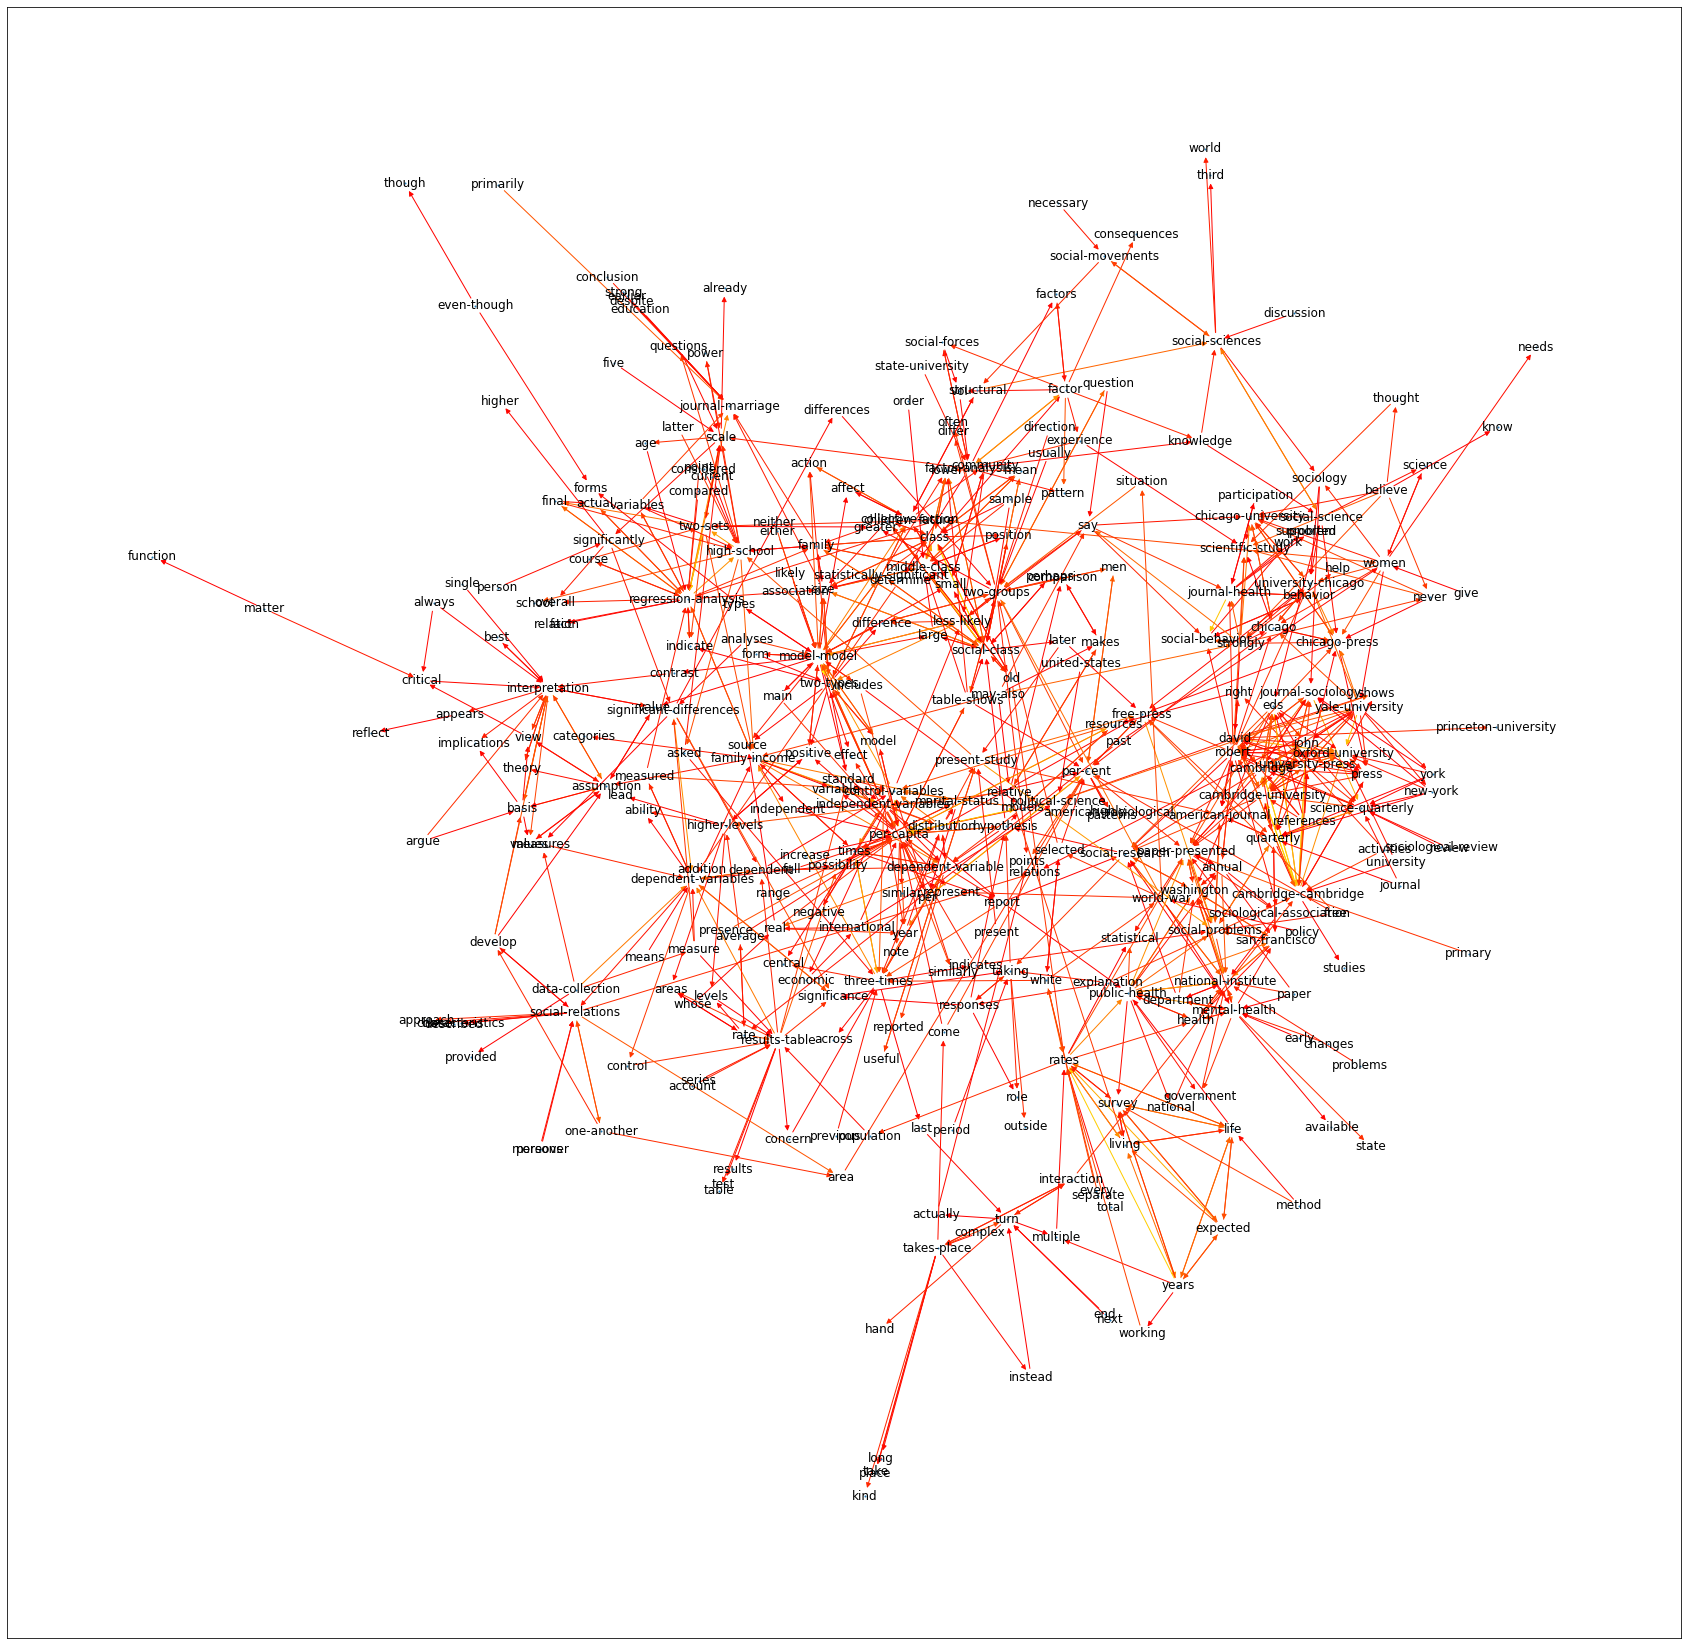

In [172]:
plt.figure(figsize=(30,30))

edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(Gcomp,'weight').items()])

c = np.log(weights)
c /= c.max()

nx.draw_networkx_edges(Gcomp,pos,edgelist=edges,edge_cmap=plt.cm.autumn,edge_color=c)
nx.draw_networkx_nodes(Gcomp,pos,node_size=1)
nx.draw_networkx_labels(Gcomp,pos)
plt.show()

# just try outputting & use Gephi

In [144]:
from csv import writer

In [146]:
with open('second_cooc.csv', 'w', encoding='utf8') as outf:
    
    w = writer(outf)
    w.writerow(['Source', 'Target', 'Weight'])
    
    for (ti1, ti2, wt) in G.edges(data='weight'):
        w.writerow([ti1,ti2,wt])

Loading this coocurrence network first_cooc.csv into Gephi produced good results.

+ there is a cluster of single-letter words a -> d -> etc... which should be ignored
+ there are many words which show up equally in articles from a given journal (i.e. extremely high entropy across journals) which should be removed
+ there are many words which show up equally in all articles, usually regarding the flow, that can be removed
+ the window should be increased, and should be modified when terms are encountered, which are always followed by the second word of the term
+ it's actually good that a given term points strongly to a word that's contained in it (that's the immediate next word)
+ there are interpretable results already, but it's clear that 1k words just isn't enough. t1.t2 is only 24M with 1k words. It's not storage, it's only memory?
+ I also need to store fy.t1.t2
+ I need to upload the whole dataset